## PLANTEAMINETO DEL PROBLEMA  

Soy Nicolas Ernesto Aguirre Tobar, Data Scientist - Ingeniero Civil en Computación mención en Informática, con el grado de Licenciatura en Ciencias de la Ingeniería, Universidad Tecnológica Metropolitana.  

Descripción del test para **Brain Food**:  

Webpro,

Como primera fase del proceso, te mandamos este desafío. Tienes hasta el Domingo 11 de Noviembre para mandarnos tu respuesta si quieres seguir en el proceso. 
Saludos,

Coni

DESAFÍO: 
Como puede ser de su conocimiento, para la ciudad de Punta Arenas, la disponibilidad de GAS es crucial. 
Por lo anterior, la autoridad ha solicitado construir un modelo estadístico que permita obtener proyecciones del consumo diario con base a la información disponible (Observación: el interés primordial es obtener predicciones diarias de 1 a 7 días, además, semanales de 1-5 semanas, y con el objetivo de negociar y prever situaciones particulares, obtener predicciones mensuales de 1 a 3 meses). 
Para lo anterior se cuenta con la información del consumo de gas natural entre el 20 de octubre de 1995 y 31 de diciembre de 2002. 
El objetivo consiste en realizar un modelo con enfoque Machine Learning para poder obtener las predicciones solicitadas. Además, se solicita entregar cualquier otro análisis que el postulante considere pertinente para llegar al modelo (o modelos) final. Además, se deben mostrar KPIs técnicos para poder evaluar la performance del modelo. 
El desarrollo se solicita que sea mediante R o Python, aunque no son excluyentes. En caso de enviar sólo un script, que sea lo más ordenado y comentado posible. 
Se evaluará la habilidad de mostrar resultados, además del nivel técnico al momento de desarrollar el modelo.  

La problemática a abordar es estudiar el consumo de gas (metros cúbicos), en la ciudad de Punta Arenas. Además, realizar una proyección de 1 a 7 días, 1 a 5 semanas y 1 a 3 meses con los datos suministrados. Para lograr este cometido, se realizarán tres fases:

1.- Recopilación de información adicional.  
2.- Análisis estadístico de los datos.  
3.- Construcción de los modelos predictivos.  
4.- Evaluación de la performance de los modelos  
5.- Proyecciones  

***Es importante mencionar que este trabajo se realizó utilizando Python y R en un mismo entorno de trabajo, dando robustez significativa a los análisis y modelos estadísticos.***

### Fase I: Recopilación de datos e información adicional

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import pareto
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')
import dateutil.relativedelta as relativedelta

plt.style.use('ggplot')
%matplotlib inline

In [2]:
timeseries = pd.read_csv('Consumo Gas Region Magallanes.csv', sep=';',encoding = 'ISO-8859-1')

In [3]:
timeseries.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,Sábado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


Los datos disponibles son:  

1.- Consumo (en metros cúbicos)  
2.- Dia  
3.- Mes  
4.- Año  
5.- Dia de semana  
6.- Si es feriado o no (variable binaria)  

Se construirá la variable *date*, que se define como Año-Mes-Día, debido a que este problema se resuelve por Series de Tiempo. Se agrupara el consumo total por año, para estudiar el porcentaje de aumento desde el año 1996 que es el primer año cerrado, debido a que el año 1995, comienza en Octubre.  

Por otro lado, recopilamos información histórica de Meteorología Chile, el cual contempla las temperaturas mensuales medias, máximas y mínimas, velocidad media de vientos, rachas máximas, presión media mensual y lluvia total mensual. Los datos obtenidos contemplan en 7 tablas.

In [4]:
pa_1996 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='1996')
pa_1997 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='1997')
pa_1998 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='1998')
pa_1999 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='1999')
pa_2000 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='2000')
pa_2001 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='2001')
pa_2002 = pd.read_excel('CLIMA PUNTA ARENAS.xlsx', sheet_name='2002')

pa_1996['Año'] = 1996
pa_1997['Año'] = 1997
pa_1998['Año'] = 1998
pa_1999['Año'] = 1999
pa_2000['Año'] = 2000
pa_2001['Año'] = 2001
pa_2002['Año'] = 2002

clima_pa = pd.concat([pa_1996,pa_1997,pa_1998, pa_1999, pa_2000, pa_2001, pa_2002]).reset_index(drop=True)

In [5]:
clima_pa['periodo'] = clima_pa.Año*100+clima_pa.MES
clima_pa['periodo'] = pd.to_datetime(clima_pa.periodo, format='%Y%m')

In [6]:
clima_pa.head()

,MES,T. MEDIA,T. MÁX,T. MÍN,V. MEDIA VIENTO,RACHAS MÁX,PRESIÓN MEDIA,LLUVIA,Año,periodo
0,1,9 °C,18 °C,1 °C,25.8 km/h,92.4 km/h,1001.9 hPa,36.2 mm,1996,1996-01-01
1,2,10 °C,19 °C,2 °C,23 km/h,81.3 km/h,1001.4 hPa,30.5 mm,1996,1996-02-01
2,3,9 °C,19 °C,1 °C,24.3 km/h,92.4 km/h,998.8 hPa,95.4 mm,1996,1996-03-01
3,4,6 °C,12 °C,0 °C,17.6 km/h,92.4 km/h,1002.2 hPa,84.1 mm,1996,1996-04-01
4,5,6 °C,11 °C,-2 °C,22.5 km/h,92.4 km/h,1000.2 hPa,60 mm,1996,1996-05-01


In [7]:
clima_pa.rename(columns={'T. MEDIA':'t_media','T. MÁX':'t_max','T. MÍN':'t_min', 'V. MEDIA VIENTO':'v_media_viento','RACHAS MÁX':'racha_max','PRESIÓN MEDIA':'presion_media','LLUVIA':'lluvia'}, inplace=True)

clima_pa['t_media'] = clima_pa['t_media'].apply(lambda x: x.split(' ')[0]).astype('int64')
clima_pa['t_max'] = clima_pa['t_max'].apply(lambda x: x.split(' ')[0]).astype('int64')
clima_pa['t_min'] = clima_pa['t_min'].apply(lambda x: x.split(' ')[0]).astype('int64')
clima_pa['v_media_viento'] = clima_pa['v_media_viento'].apply(lambda x: x.split(' ')[0]).astype('float64')
clima_pa['racha_max'] = clima_pa['racha_max'].apply(lambda x: x.split(' ')[0]).astype('float64')
clima_pa['presion_media'] = clima_pa['presion_media'].apply(lambda x: x.split(' ')[0]).astype('float64')
clima_pa['lluvia'] = clima_pa['lluvia'].apply(lambda x: x.split(' ')[0]).astype('float64')

### Fase II: Análisis estadístico de los datos

### 1.-  Análisis anual

In [8]:
# Sacamos el consumo total, también el porcentaje de crecimiento a partir del año 1996

consumo_anual = timeseries.groupby('Año').agg({'Consumo':sum})

base = consumo_anual[consumo_anual.index==1996].Consumo.values[0]

consumo_anual['total_base'] = base
consumo_anual['delta_consumo'] = (consumo_anual['Consumo']-consumo_anual['total_base'])
consumo_anual['porc_variacion'] =round((consumo_anual['delta_consumo'] / consumo_anual['total_base']) * 100, 2)

consumo_anual.porc_variacion.iloc[0] = 0
consumo_anual['Año'] = consumo_anual.index.astype('int64')

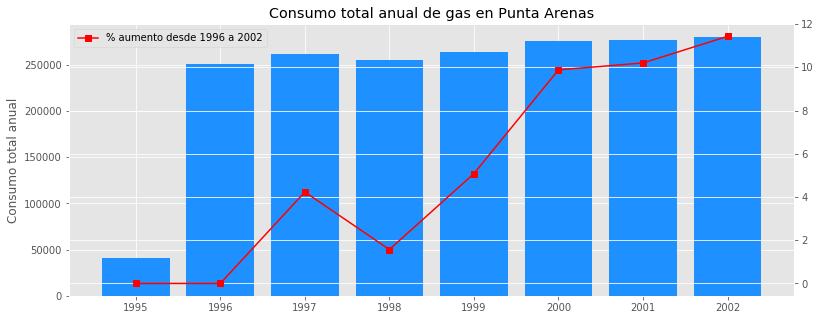

In [9]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(consumo_anual.Año,consumo_anual['Consumo'],color='dodgerblue')
plt.ylabel('Consumo total anual')

ax2 = ax1.twinx()

ax2.plot(consumo_anual.Año,consumo_anual['porc_variacion'],color='red', marker='s', label = '% aumento desde 1996 a 2002')


plt.title('Consumo total anual de gas en Punta Arenas')
plt.legend()
plt.show()

Como se puede observar en el gráfico, hubo un aumento total del consumo anual cercano a un 12% desde el año 1996 al año 2002, disminuyendo la tasa de crecimiento del año 2000 al 2002.  

A continuación se agruparán los datos de forma semanal y mensual, tomando el consumo total por dia, esto representará la demanda total en los periodos respectivos.

In [10]:
#Creamos la variable 'date' a partir de las variables Año-Mes-Dia

timeseries['date'] = timeseries.Año.map(str)+'-'+timeseries.Mes.map(str)+'-'+timeseries.Dia.map(str)
timeseries['date'] = pd.to_datetime(timeseries.date)

In [11]:
# Agrupamos de 7 días a partir del 2002-12-31 (última fecha), sumando el consumo total semanal

timeseries.sort_values('date',ascending=False,inplace=True)
timeseries['week'] = 1

for i in range(0, timeseries.shape[0],7):
    timeseries.loc[timeseries.index[i:i+7], 'week'] = timeseries.loc[timeseries.index[i:i+7], 'date'].max()
    
consum_week = timeseries.groupby('week',as_index=False).agg({'Consumo':[sum,'count']})

consum_week.columns = ['_'.join(col).strip() for col in consum_week.columns.values]
consum_week.rename(columns={'week_':'week'},inplace=True)

consum_week = consum_week[consum_week['Consumo_count'] == 7]
consum_week = consum_week[['week','Consumo_sum']]

In [12]:
# Agrupamos de mensual a partir del 2002-12-31 (última fecha), sumando el consumo total mensual

timeseries['period_monthly'] = timeseries.date.dt.year*100 + timeseries.date.dt.month

timeseries = timeseries.sort_values('period_monthly')

consum_month = timeseries.groupby('period_monthly',as_index=False).agg({'date':min,'Consumo':sum})
consum_month = consum_month[consum_month.index != consum_month.index[0]]

In [13]:
# Guardamos las agrupaciones anteriores, para utilizarlas en %%R

consum_week.rename(columns={'week':'periodo','Consumo_sum':'Consumo'},inplace=True)
consum_month.rename(columns={'date':'periodo'},inplace=True)

consum_week.to_csv('./consumo_semanal.csv',sep=';',index=False)
consum_month.to_csv('./consumo_mensual.csv',sep=';',index=False)

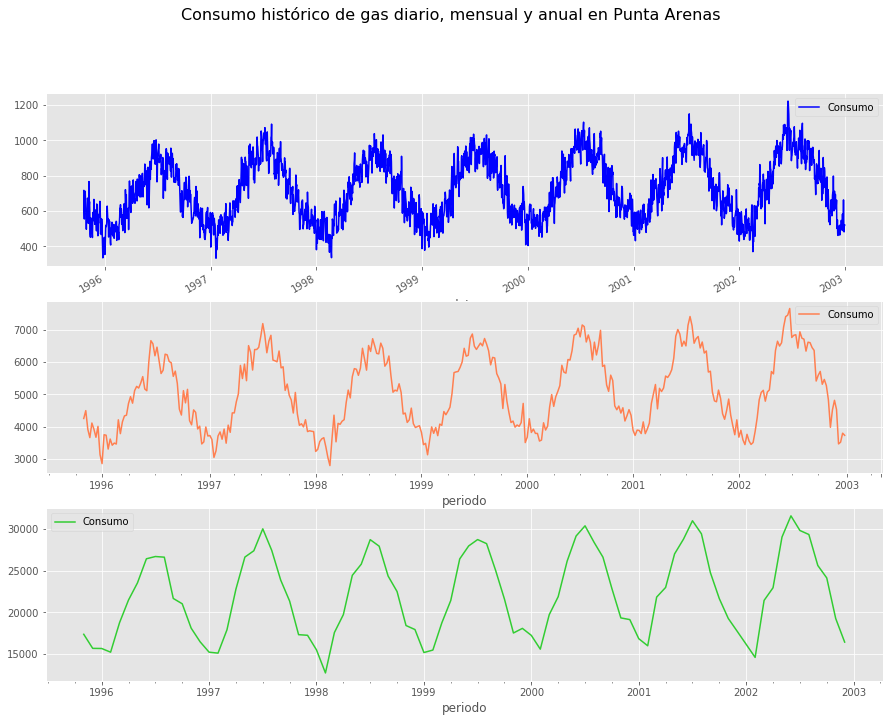

In [14]:
fig = plt.figure(figsize=(15, 12))

g1 = fig.add_subplot(311)
g2 = fig.add_subplot(312)
g3 = fig.add_subplot(313)

g1 = timeseries.plot(x='date',y='Consumo',color='blue', ax=g1)
g2 = consum_week.plot(x='periodo', y='Consumo', color='coral', ax=g2)
g3 = consum_month.plot(x='periodo', y='Consumo', color='limegreen', ax=g3)

fig.suptitle('Consumo histórico de gas diario, mensual y anual en Punta Arenas', fontsize=16)
plt.show()

Como muestra el grafico, la distribucion de los datos se comporta relativamente de forma estacional, debido a que el crecimiento anual no supera el 12% a lo largo de los 7 años, sin alterar la tendencia y estacionalidad.

### 2.- Análisis mensual

In [15]:
# Aplicamos la función 'calendar.month_abbr', que nos da el nombre del mes abreviado asociado al número de mes

timeseries['month'] = timeseries.Mes.apply(lambda x: calendar.month_abbr[x])

timeseries.sort_values('Mes',inplace=True)

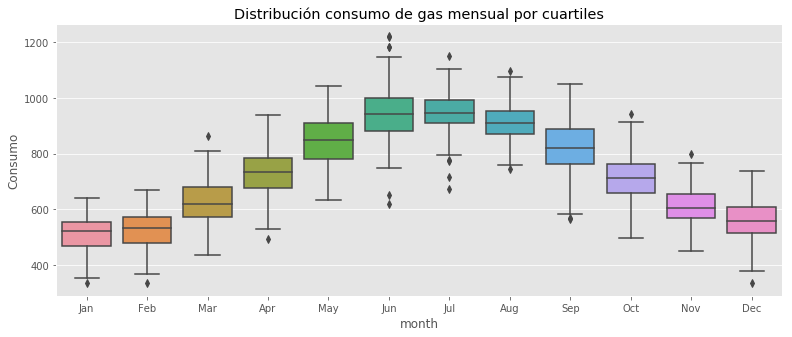

In [16]:
fig= plt.subplots(figsize=(13,5))

g = sns.boxplot(x='month',y='Consumo',data=timeseries)

plt.title('Distribución consumo de gas mensual por cuartiles')
plt.show()

En el gráfico anterior, podemos notar cómo se comporta la distribución de los datos, por periodos mensuales representado por cuartiles. Como se observó anteriormente, la dispersión de los datos es similar con respecto a los años, por esto la distribución de los datos de forma mensual como media del total de años es representativo, indicándonos alguna tendencia.  

Podemos concluir que en los periodos de Marzo a Julio existe una marcada alza en el consumo de gas, así como de Agosto a Noviembre se muestra una baja considerable en el consumo de gas. Este comportamiento se puede deber a la estacionalidad del año, ya que Chile está ubicado en el Hemisferio Sur, siendo los meses de alza, los periodos más fríos del año.

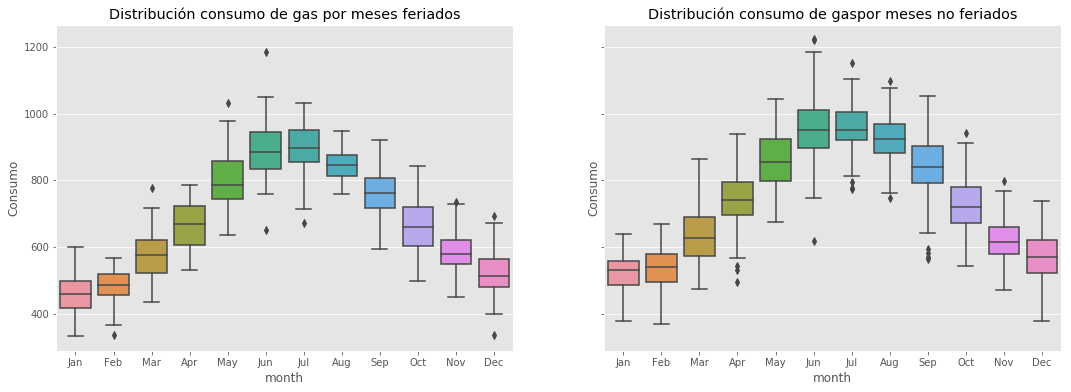

In [17]:
feriados = timeseries[timeseries['Feriado'] == 1]
feriados.sort_values('Mes',inplace=True)

no_feriados = timeseries[timeseries['Feriado'] == 0]
no_feriados.sort_values('Mes',inplace=True)

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(18,6), sharey=True)

ax1 = sns.boxplot(x='month',y='Consumo',data=feriados, ax=ax1)
ax1.set_title('Distribución consumo de gas por meses feriados')

ax2 = sns.boxplot(x='month',y='Consumo',data=no_feriados, ax=ax2)
ax2.set_title('Distribución consumo de gaspor meses no feriados')

plt.show()

Se hace una comparativa del consumo de gas entre días Feriados y no feriados medios por cada mes. En el gráfico se muestra una variación mínima en los datos, dejando en evidencia un mayor consumo total para días no feriados, esto puede deberse a la cantidad total de días de cada distribución, siendo los feriados inferiores en cantidad de dias, aun así, la variación es mínima.

In [18]:
# Agrupamos por mes separados por los días feriados y no feriados

ff = feriados.groupby(['month','Mes'],as_index=False).agg({'Consumo':'mean','Feriado':'count'})
nf = no_feriados.groupby(['month','Mes'],as_index=False).agg({'Consumo':'mean','Feriado':'count'})

ff['consumo_diario'] = ff.Consumo/ff.Feriado
nf['consumo_diario'] = nf.Consumo/nf.Feriado

ff.sort_values('Mes',inplace=True)
nf.sort_values('Mes',inplace=True)

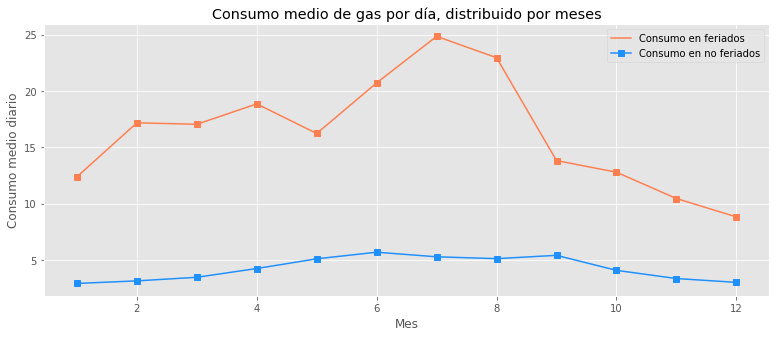

In [19]:
fig, g= plt.subplots(figsize=(13,5))

g = ff.plot(x='Mes',y='consumo_diario', label='Consumo en feriados', marker='s', color='coral',ax=g)
g = nf.plot(x='Mes',y='consumo_diario',label='Consumo en no feriados', marker='s', color='dodgerblue', ax=g)

plt.title('Consumo medio de gas por día, distribuido por meses')
plt.ylabel('Consumo medio diario')
plt.show()

Queda en evidencia, que hay un mayor consumo por día, asociado a los feriados, esto es evidente, debido a que las personas permanecen más tiempo en sus hogares. Sin embargo, es necesario tomar en cuenta este dato.

In [20]:
# Determinamos el coeficiente de variación para la distribución mensual, para ello extraemos la media y la desviación estándar

consumo_mensual = timeseries.groupby('Mes',as_index=False).agg({'Consumo':['mean','std']})

consumo_mensual.columns = ['_'.join(col).strip() for col in consumo_mensual.columns.values]
consumo_mensual.rename(columns={'Mes_':'Mes'},inplace=True)
consumo_mensual['month'] = consumo_mensual.Mes.apply(lambda x: calendar.month_abbr[x])

consumo_mensual['Coeficiente_variacion'] = consumo_mensual.Consumo_std / consumo_mensual.Consumo_mean

In [21]:
consumo_mensual['pxmes'] = consumo_mensual.Consumo_mean.shift(1)

In [22]:
consumo_mensual['porc_variacion_mxm'] = (consumo_mensual.Consumo_mean - consumo_mensual.pxmes) / consumo_mensual.pxmes

In [23]:
consumo_mensual

,Mes,Consumo_mean,Consumo_std,month,Coeficiente_variacion,pxmes,porc_variacion_mxm
0,1,514.474654,59.912286,Jan,0.116453,NaN,NaN
1,2,527.914141,63.667503,Feb,0.120602,514.474654,0.026123
2,3,626.193548,83.691339,Mar,0.133651,527.914141,0.186166
3,4,729.552381,85.017474,Apr,0.116534,626.193548,0.165059
4,5,844.456221,85.293389,May,0.101004,729.552381,0.157499
5,6,938.919048,90.202261,Jun,0.096070,844.456221,0.111862
6,7,946.898618,72.129762,Jul,0.076175,938.919048,0.008499
7,8,910.156682,67.534719,Aug,0.074201,946.898618,-0.038802
8,9,819.009524,92.564783,Sep,0.113020,910.156682,-0.100144
9,10,709.864629,80.617812,Oct,0.113568,819.009524,-0.133265


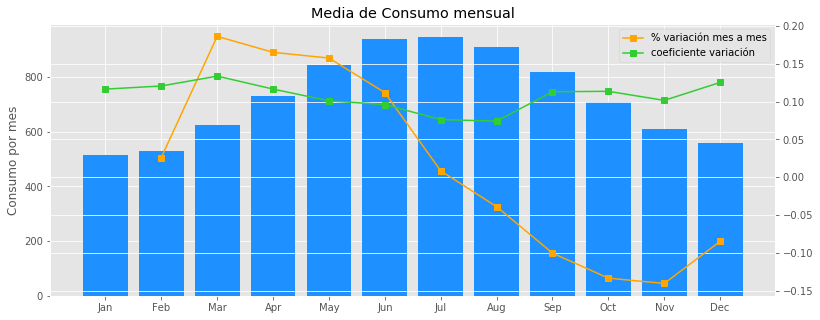

In [24]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(consumo_mensual.month,consumo_mensual.Consumo_mean,color='dodgerblue')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(consumo_mensual.month,consumo_mensual['porc_variacion_mxm'],color='orange', marker='s', label="% variación mes a mes")
ax2.plot(consumo_mensual.month,consumo_mensual['Coeficiente_variacion'],color='limegreen', marker='s', label="coeficiente variación")
plt.legend()

plt.title('Media de Consumo mensual')

plt.show()

Estudiamos anteriormente la distribución del consumo mensual de gas en Punta Arenas, tomando un promedio por cada mes a lo largo de los años, debido a que el consumo se comportaba de manera estacional, es por esto que verificamos el coeficiente de variación por cada mes, a partir del año 1996 al año 2002.  

El coeficiente de variación oscila entre 10% y 15%, esto quiere decir que existe poca variabilidad o una variación muy aceptable, esto quiere decir que es representativa la media del consumo por cada mes, desde Enero de 1996 hasta Diciembre de 2002.

In [25]:
timeseries = timeseries.sort_values('period_monthly')

consum_month2 = timeseries.groupby('period_monthly',as_index=False).agg({'date':min,'Consumo':sum,'Feriado':'mean'})
consum_month2 = consum_month2[consum_month2.index != consum_month2.index[0]]

consum_month2.rename(columns={'date':'periodo'},inplace=True)

In [26]:
clima = pd.merge(consum_month2[consum_month2['periodo'] >= datetime(1996,1,1)], clima_pa, on='periodo', how='left')

In [27]:
clima.head()

,period_monthly,periodo,Consumo,Feriado,MES,t_media,t_max,t_min,v_media_viento,racha_max,presion_media,lluvia,Año
0,199601,1996-01-01,15642,0.161290,1,9,18,1,25.8,92.4,1001.9,36.2,1996
1,199602,1996-02-01,15198,0.137931,2,10,19,2,23.0,81.3,1001.4,30.5,1996
2,199603,1996-03-01,18751,0.161290,3,9,19,1,24.3,92.4,998.8,95.4,1996
3,199604,1996-04-01,21472,0.166667,4,6,12,0,17.6,92.4,1002.2,84.1,1996
4,199605,1996-05-01,23533,0.225806,5,6,11,-2,22.5,92.4,1000.2,60.0,1996


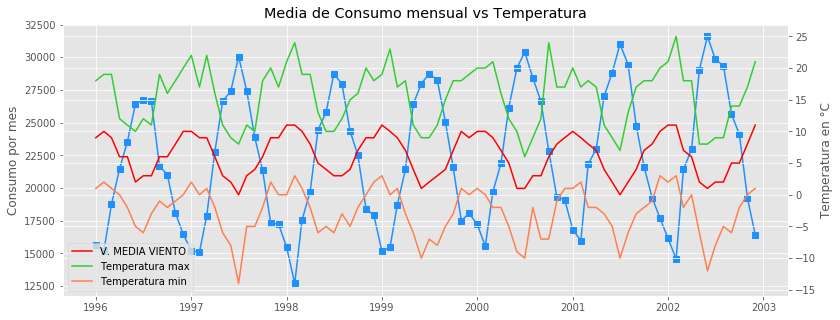

In [28]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.plot(clima.periodo,clima.Consumo,color='dodgerblue',marker='s')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima.periodo,clima['t_media'],color='red', label="V. MEDIA VIENTO")
ax2.plot(clima.periodo,clima['t_max'],color='limegreen', label="Temperatura max")
ax2.plot(clima.periodo,clima['t_min'],color='coral', label="Temperatura min")
plt.legend()

plt.title('Media de Consumo mensual vs Temperatura')
plt.ylabel('Temperatura en °C')
plt.show()

Se puede observar en los picos superiores de consumo, hay bajas en las temperaturas de Punta Arenas, en contraste a los picos inferiores de consumo, se debe a las alzas de temperaturas.

In [29]:
clima_mensual = clima.groupby('MES',as_index=False).agg({'Consumo':'mean','t_media':'mean','t_max':'mean','t_min':'mean'})
clima_mensual['month'] = clima_mensual.MES.apply(lambda x: calendar.month_abbr[x])

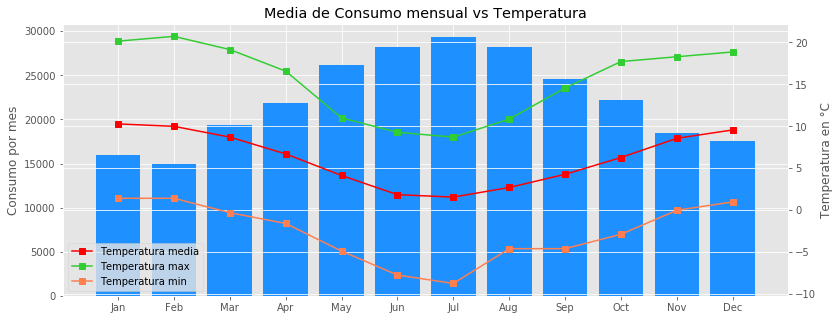

In [30]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(clima_mensual.month,clima_mensual.Consumo,color='dodgerblue')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima_mensual.month,clima_mensual['t_media'],color='red',marker='s', label="Temperatura media")
ax2.plot(clima_mensual.month,clima_mensual['t_max'],color='limegreen',marker='s', label="Temperatura max")
ax2.plot(clima_mensual.month,clima_mensual['t_min'],color='coral', marker='s',label="Temperatura min")
plt.legend()

plt.title('Media de Consumo mensual vs Temperatura')
plt.ylabel('Temperatura en °C')
plt.show()

Como se puede inferir, las temperaturas son un factor ponderante en el consumo de gas, como se muestra en la figura, a la baja de temperatura, se refleja un alza en el consumo directo de gas. Se tomaron en cuenta, las temperaturas máximas mínimas y media en el mes.


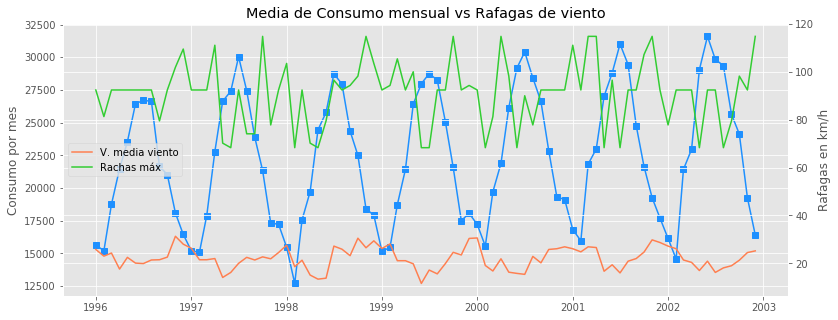

In [31]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.plot(clima.periodo,clima.Consumo,color='dodgerblue',marker='s')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima.periodo,clima['v_media_viento'],color='coral', label="V. media viento")
ax2.plot(clima.periodo,clima['racha_max'],color='limegreen', label="Rachas máx")
plt.legend()

plt.title('Media de Consumo mensual vs Rafagas de viento')
plt.ylabel('Rafagas en km/h')
plt.show()

In [32]:
clima_mensual = clima.groupby('MES',as_index=False).agg({'Consumo':'mean','v_media_viento':'mean','racha_max':'mean'})
clima_mensual['month'] = clima_mensual.MES.apply(lambda x: calendar.month_abbr[x])

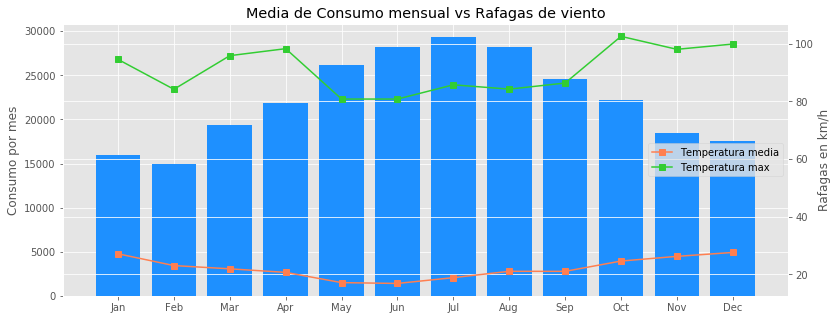

In [33]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(clima_mensual.month,clima_mensual.Consumo,color='dodgerblue')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima_mensual.month,clima_mensual['v_media_viento'],color='coral',marker='s', label="Temperatura media")
ax2.plot(clima_mensual.month,clima_mensual['racha_max'],color='limegreen',marker='s', label="Temperatura max")
plt.legend()

plt.title('Media de Consumo mensual vs Rafagas de viento')
plt.ylabel('Rafagas en km/h')
plt.show()

Como queda en evidencia, las rafagas de viento, no son incidentes en el consumo de gas en punta arenas.

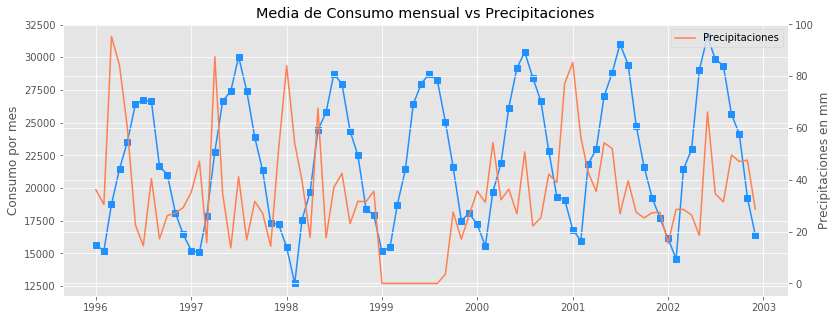

In [34]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.plot(clima.periodo,clima.Consumo,color='dodgerblue',marker='s')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima.periodo,clima['lluvia'],color='coral', label="Precipitaciones")
plt.legend()

plt.title('Media de Consumo mensual vs Precipitaciones')
plt.ylabel('Precipitaciones en mm')
plt.show()

In [35]:
clima_mensual = clima.groupby('MES',as_index=False).agg({'Consumo':'mean','lluvia':'mean'})
clima_mensual['month'] = clima_mensual.MES.apply(lambda x: calendar.month_abbr[x])

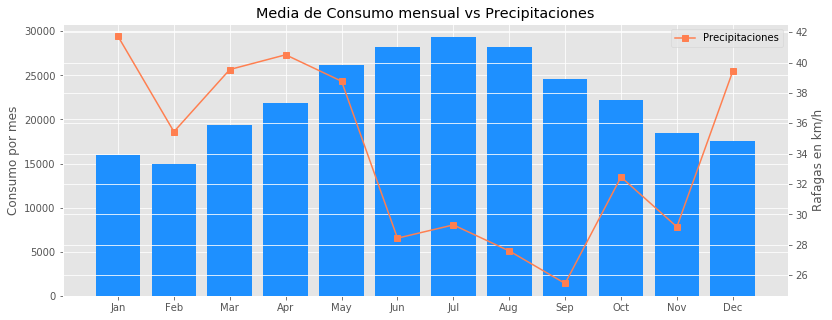

In [36]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(clima_mensual.month,clima_mensual.Consumo,color='dodgerblue')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima_mensual.month,clima_mensual['lluvia'],color='coral',marker='s', label="Precipitaciones")
plt.legend()

plt.title('Media de Consumo mensual vs Precipitaciones')
plt.ylabel('Rafagas en km/h')
plt.show()

Las precipitaciones no inciden en el consumo de gas, sin embargo, pueden tener incidencia con respecto a las temperaturas, debido a que existe un alza hasta principios de Junio, existiendo un gran descenso a partir de este mes, viendo en este periodo una disminución considerable en las temperaturas. Esto podría adherirse al análisis, debido a que puede considerarse una variable ponderante en la variable temperatura, y como vimos anteriormente, es una variable fundamental en el consumo de gas en Punta Arenas.

In [37]:
clima_mensual = clima.groupby('MES',as_index=False).agg({'t_media':'mean','lluvia':'mean'})
clima_mensual['month'] = clima_mensual.MES.apply(lambda x: calendar.month_abbr[x])

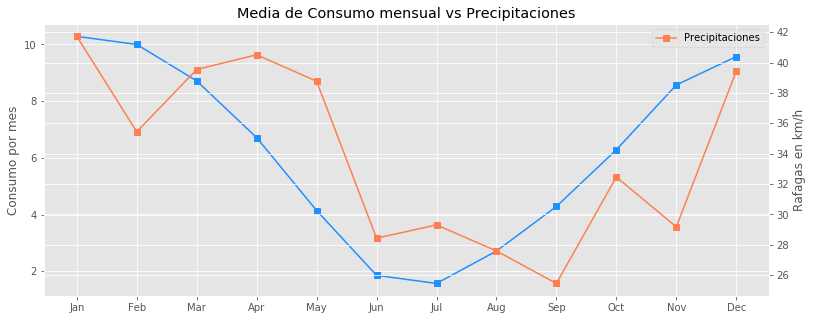

In [38]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.plot(clima_mensual.month,clima_mensual.t_media,marker='s',color='dodgerblue')
plt.ylabel('Consumo por mes')

ax2 = ax1.twinx()

ax2.plot(clima_mensual.month,clima_mensual['lluvia'],color='coral',marker='s', label="Precipitaciones")
plt.legend()

plt.title('Media de Consumo mensual vs Precipitaciones')
plt.ylabel('Rafagas en km/h')
plt.show()

Existe una notoria correlación con respecto a las temperaturas y las precipitaciones.

### 3.- Análisis por estaciones

In [39]:
#Asignamos estaciones del año, asociado a los meses

timeseries['estacion'] = np.where(timeseries['Mes'] <= 3,'Verano',np.where((timeseries['Mes'] >= 4) & (timeseries['Mes'] <= 6),'Otoño',np.where((timeseries['Mes'] >= 7) & (timeseries['Mes'] <= 9),'Invierno',np.where((timeseries['Mes'] >= 10) & (timeseries['Mes'] <= 12),'Primavera',None))))
timeseries.sort_values('Mes',inplace=True)

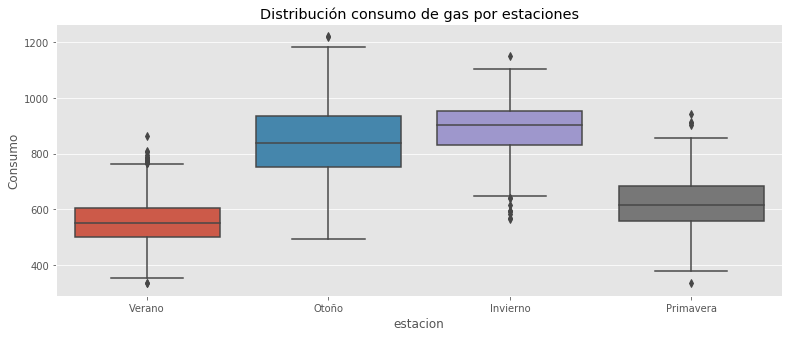

In [40]:
fig= plt.subplots(figsize=(13,5))

g = sns.boxplot(x='estacion',y='Consumo',data=timeseries)

plt.title('Distribución consumo de gas por estaciones')
plt.show()

Como dijimos anteriormente, el alza del consumo mensual, estaba asociado a las estaciones del año, estas estaciones corresponden al Hemisferio Sur, y están ordenadas desde Enero-Diciembre. El alza es significativa para la estación de Otoño e Invierno, esto es evidente, debido a las condiciones climáticas extremas de Punta Arenas.

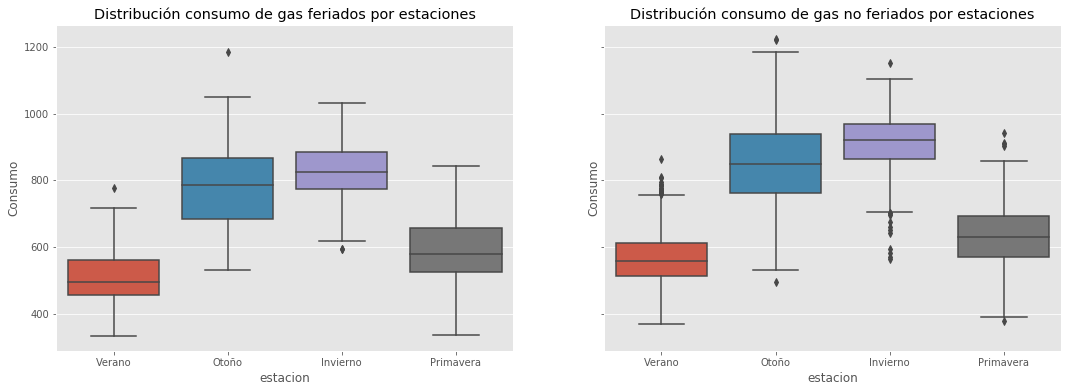

In [41]:
feriados = timeseries[timeseries['Feriado'] == 1]
feriados.sort_values('Mes',inplace=True)

no_feriados = timeseries[timeseries['Feriado'] == 0]
no_feriados.sort_values('Mes',inplace=True)

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(18,6), sharey=True)

ax1 = sns.boxplot(x='estacion',y='Consumo',data=feriados, ax=ax1)
ax1.set_title('Distribución consumo de gas feriados por estaciones')

ax2 = sns.boxplot(x='estacion',y='Consumo',data=no_feriados, ax=ax2)
ax2.set_title('Distribución consumo de gas no feriados por estaciones')

plt.show()

Podemos ver que el consumo se comporta similar en días feriados y no feriados, como demostramos anteriormente, esto quiere decir que en los días feriados se consume más gas por día, en contraste a los días no feriados.

## Fase III Construcción de los modelos predictivos.

Se utilizo la libreria rpy2 para utilizar R + Python en Jupyter Notebook, en este trabajo R se utilizó para construir los modelos Prophet y Python para el análisis descriptivo. Se crearon 3 modelos que varían en su periodo, estos son diarios, mensuales y semanales, de esta forma el modelo podrá predecir consumo total por semana y mes. Además, se tomaron en cuenta los holidays en los modelos, otorgando un mejor ajuste para el modelo.  

Para estudiar la certeza del modelo, se hizo un split para train y test, cortando el último año para los tres modelos, esto quiere decir que la data para el *cross validation* es para el año 2002.


In [42]:
# configuramos las variables de entorno
import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-3.4.4' #derección de instalación de R
os.environ['R_USER'] = 'C:\Python36\Lib\site-packages\rpy2' #direccion donde instalo el paquete rpy2 Python

In [43]:
import rpy2.rinterface

% load_ext rpy2.ipython

In [44]:
%%R -o forecast_days -o forecast_months -o forecast_weeks -o accuracy_days -o accuracy_months -o accuracy_weeks
#-o df_cv -o df_cv2 -o df_cv3

library(forecast)
library(RODBC)
library(prophet)
library(dplyr)

#######################################################################################
#                              Preparamos los datos                                   #
#######################################################################################

timeseries <- read.csv('Consumo Gas Region Magallanes.csv',sep=';')
paste(timeseries$Año,timeseries$Mes,timeseries$Dia, collapse="-")

timeseries$periodo <- apply( timeseries[ , c( 'Año' , 'Mes' , 'Dia' ) ] , 1 , paste , collapse = "-" )
timeseries$periodo <- as.Date(timeseries$periodo, "%Y-%m-%d")

# timeseries <- timeseries[timeseries$periodo >= '1996-01-01',]

#######################################################################################
#                              Datos por periodo semanal                              #
#######################################################################################

consumo_semanal <- read.csv('consumo_semanal.csv',sep=';')
consumo_semanal$periodo <- as.Date(consumo_semanal$periodo, "%Y-%m-%d")

#######################################################################################
#                           Datos por periodo mensual                                 #
#######################################################################################

consumo_mensual <- read.csv('consumo_mensual.csv',sep=';')
consumo_mensual$periodo <- as.Date(consumo_mensual$periodo, "%Y-%m-%d")

#######################################################################################
#                             Contemplamos los feriados                               #
#######################################################################################

feriados <- data_frame(
holiday = 'feriado',
ds = timeseries[timeseries$Feriado == 1,]$periodo,
lower_window = 0,
upper_window = 1)

holidays <- bind_rows(feriados)

#######################################################################################
#                             Entrenamiento y predicción                              #
#######################################################################################

##### Modelo por dias

timeseries <- timeseries[timeseries$periodo >= '1996-01-01',]

model <- prophet(data.frame(ds=timeseries$periodo, y=timeseries$Consumo), holidays = holidays,  
                 yearly.seasonality = TRUE, daily.seasonality = TRUE, weekly.seasonality = TRUE,n.changepoints = 21)

futuro_days <- make_future_dataframe(model, periods = 7,freq = "days",include_history = FALSE)

forecast_days <- predict(model, futuro_days)
forecast_days <- forecast_days[,c('ds','yhat')]
colnames(forecast_days) <- c('periodo', 'prediccion_consumo')
forecast_days$prediccion_consumo <- as.integer(forecast_days$prediccion_consumo)
forecast_days$periodo <- as.character.Date(forecast_days$periodo)

##### Modelo por semanas

model <- prophet(data.frame(ds=consumo_semanal$periodo, y=consumo_semanal$Consumo),  yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_weeks <- make_future_dataframe(model, periods = 5,freq = "week",include_history = FALSE)

forecast_weeks <- predict(model, futuro_weeks)
forecast_weeks <- forecast_weeks[,c('ds','yhat')]
colnames(forecast_weeks) <- c('periodo', 'prediccion_consumo')
forecast_weeks$prediccion_consumo <- as.integer(forecast_weeks$prediccion_consumo)
forecast_weeks$periodo <- as.character.Date(forecast_weeks$periodo)

##### Modelo por meses

model <- prophet(data.frame(ds=consumo_mensual$periodo, y=consumo_mensual$Consumo),  yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_months <- make_future_dataframe(model, periods = 3,freq = "months",include_history = FALSE)

forecast_months <- predict(model, futuro_months)
forecast_months <- forecast_months[,c('ds','yhat')]
colnames(forecast_months) <- c('periodo', 'prediccion_consumo')
forecast_months$prediccion_consumo <- as.integer(forecast_months$prediccion_consumo)
forecast_months$periodo <- as.character.Date(forecast_months$periodo)

#######################################################################################
#                          Estudiamos la certeza del modelo                           #
#######################################################################################

timeseries <- timeseries[which(!timeseries$periodo %in% tail(timeseries, 365)$periodo),]
consumo_semanal <- consumo_semanal[which(!consumo_semanal$periodo %in% tail(consumo_semanal, 52)$periodo),]
consumo_mensual <- consumo_mensual[which(!consumo_mensual$periodo %in% tail(consumo_mensual, 12)$periodo),]

##### Modelo por dias

model <- prophet(data.frame(ds=timeseries$periodo, y=timeseries$Consumo), holidays = holidays, 
                 yearly.seasonality = TRUE, daily.seasonality = TRUE, weekly.seasonality = TRUE,n.changepoints = 21)

futuro_days <- make_future_dataframe(model, periods = 365,freq = "days",include_history = FALSE)

accuracy_days <- predict(model, futuro_days)
accuracy_days <- accuracy_days[,c('ds','yhat')]
colnames(accuracy_days) <- c('periodo', 'prediccion_consumo')
accuracy_days$prediccion_consumo <- as.integer(accuracy_days$prediccion_consumo)
accuracy_days$periodo <- as.character.Date(accuracy_days$periodo)

##### Modelo por semanas

model <- prophet(data.frame(ds=consumo_semanal$periodo, y=consumo_semanal$Consumo), yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_weeks <- make_future_dataframe(model, periods = 52,freq = "week",include_history = FALSE)

accuracy_weeks <- predict(model, futuro_weeks)
accuracy_weeks <- accuracy_weeks[,c('ds','yhat')]
colnames(accuracy_weeks) <- c('periodo', 'prediccion_consumo')
accuracy_weeks$prediccion_consumo <- as.integer(accuracy_weeks$prediccion_consumo)
accuracy_weeks$periodo <- as.character.Date(accuracy_weeks$periodo)

##### Modelo por meses

model <- prophet(data.frame(ds=consumo_mensual$periodo, y=consumo_mensual$Consumo), yearly.seasonality = TRUE, weekly.seasonality = TRUE ,n.changepoints = 21)

futuro_months <- make_future_dataframe(model, periods = 12,freq = "months",include_history = FALSE)

accuracy_months <- predict(model, futuro_months)
accuracy_months <- accuracy_months[,c('ds','yhat')]
colnames(accuracy_months) <- c('periodo', 'prediccion_consumo')
accuracy_months$prediccion_consumo <- as.integer(accuracy_months$prediccion_consumo)
accuracy_months$periodo <- as.character.Date(accuracy_months$periodo)



In [45]:
accuracy_days.periodo = pd.to_datetime(accuracy_days.periodo, format='%Y-%m-%d')
accuracy_weeks.periodo = pd.to_datetime(accuracy_weeks.periodo, format='%Y-%m-%d')
accuracy_months.periodo = pd.to_datetime(accuracy_months.periodo, format='%Y-%m-%d')

forecast_days.periodo = pd.to_datetime(forecast_days.periodo, format='%Y-%m-%d')
forecast_weeks.periodo = pd.to_datetime(forecast_weeks.periodo, format='%Y-%m-%d')
forecast_months.periodo = pd.to_datetime(forecast_months.periodo, format='%Y-%m-%d')


## Fase IV: Evaluación de la performance de los modelos  

A continuación haremos la evaluación del modelo, para esto se hará un cross validation para el año 2002, estudiaremos cómo se comporta el modelo con valores conocidos, con esto contrastaremos los valores *predictivos* y los valores *observados*. Para calcular el error entre los conjuntos de datos *Predictivos* y *Observados*, utilizamos el **Error Medio Cuadrático (RMSE)**, que se describe a continuación:

\begin{equation*}
RMSE = \sqrt{ \frac{\sum_{i=1}^n \left( P_i - O_i \right)^2 }{n}}
\end{equation*}

Para evaluar la certeza del modelo, utilizamos el **Criterio de certeza (Ceff)**, deduce si el *RMSE* es aceptable o no aceptable, el *Ceff* se describe a continuación, siendo *SD* desviación estándar:


\begin{equation*}
Ceff = 1 - \left(\frac{RMSE}{SD}\right)^2
\end{equation*}

A continuación se adjunta la tabla del **Criterio de Evaluación** por Ceff:

| Evaluación | Ceff   |
|------|------|
|   Muy bueno  | $\ge$ 0.91|
|   Bueno  | 0.84 - 0.91|
|   Aceptable  | 0.75 - 0.84|
|   No aceptable  | $\lt$ 0.75|

Otro criterio que puede utilizarse es el Criterio de Evaluación de Error Medio Cuadratico, se mide de forma porcentual, este se definira como **CERMSE** y se define a continuación:

\begin{equation*}
CERMSE = \left(\frac{RMSE}{SD}\right)*100
\end{equation*}

| Evaluación | CERMSE   |
|------|------|
|   Muy bueno  | $\le$ 30%|
|   Bueno  | 30% - 40% |
|   Aceptable  | 40% - 50% |
|   No aceptable  | $\gt$ 50%|

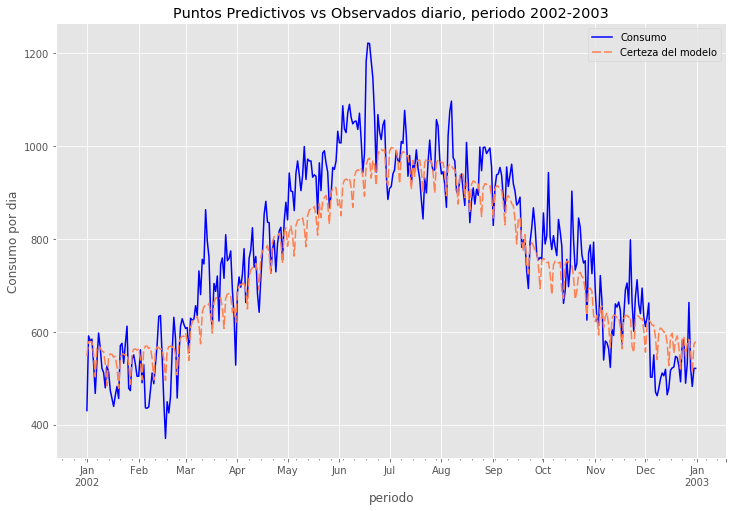

In [46]:
fig , g= plt.subplots(figsize=(12, 8))

g = timeseries.sort_values('date')[-365:].plot(x='date',y='Consumo',color='blue', ax=g)
g = accuracy_days[-365:].plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)

g.set_title('Puntos Predictivos vs Observados diario, periodo 2002-2003')

plt.ylabel('Consumo por dia')
plt.show()

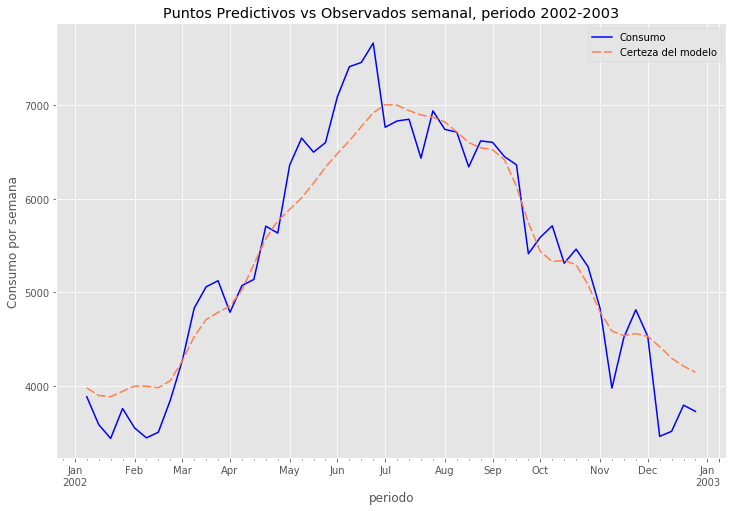

In [47]:
fig , g= plt.subplots(figsize=(12, 8))
g = consum_week[-52:].plot(x='periodo',y='Consumo',color='blue', ax=g)
g = accuracy_weeks.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)

g.set_title('Puntos Predictivos vs Observados semanal, periodo 2002-2003')

plt.ylabel('Consumo por semana')
plt.show()

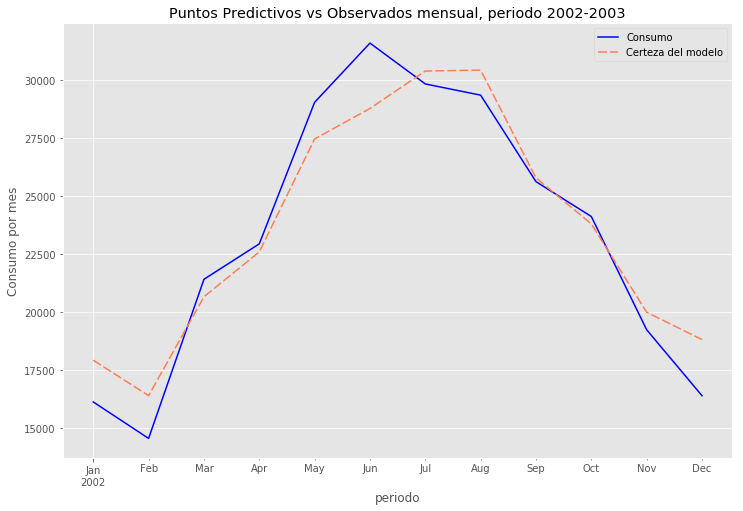

In [48]:
fig , g= plt.subplots(figsize=(12, 8))

g = consum_month[-12:].plot(x='periodo',y='Consumo',color='blue', ax=g)
g = accuracy_months.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)

g.set_title('Puntos Predictivos vs Observados mensual, periodo 2002-2003')

plt.ylabel('Consumo por mes')
plt.show()

### Error medio cuadrático para la distribución diaria

In [49]:
RMSE_days = pd.concat([accuracy_days[-365:].prediccion_consumo,  timeseries.sort_values('date')[-365:].Consumo.reset_index(drop=True)], axis=1)
RMSE_days['delta'] = (RMSE_days.prediccion_consumo - RMSE_days.Consumo)**2

In [50]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

ceffd = (1-(math.sqrt(RMSE_days.delta.sum() / RMSE_days.shape[0]) / RMSE_days.Consumo.std())**2)
cermsed = (math.sqrt(RMSE_days.delta.sum() / RMSE_days.shape[0]) / RMSE_days.Consumo.std())*100

print('Ceff modelo diario: ', ceffd)
print('Criterio de Evluación de Error Medio Cuadratico: ', cermsed)

Ceff modelo diario:  0.8470674238084274
Criterio de evluación de error medio cuadratico


### Error medio cuadratico para la distribución semanal

In [51]:
RMSE_weeks = pd.concat([accuracy_weeks.prediccion_consumo,  consum_week.sort_values('periodo')[-52:].Consumo.reset_index(drop=True)], axis=1)
RMSE_weeks['delta'] = (RMSE_weeks.prediccion_consumo - RMSE_weeks.Consumo)**2

In [52]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

ceffs = (1-(math.sqrt(RMSE_weeks.delta.sum() / RMSE_weeks.shape[0]) / RMSE_weeks.Consumo.std())**2)
cermses = (math.sqrt(RMSE_weeks.delta.sum() / RMSE_weeks.shape[0]) / RMSE_weeks.Consumo.std())*100

print('Ceff modelo semanal: ', ceffs)
print('Criterio de Evluación de Error Medio Cuadratico: ', cermses)

Ceff modelo semanal:  0.9140809217824611
Criterio de evluación de error medio cuadratico


### Error medio cuadrático para la distribución mensual

In [53]:
RMSE_months = pd.concat([accuracy_months.prediccion_consumo,  consum_month.sort_values('periodo')[-12:].Consumo.reset_index(drop=True)], axis=1)
RMSE_months['delta'] = (RMSE_months.prediccion_consumo - RMSE_months.Consumo)**2

In [54]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

ceffm = (1-(math.sqrt(RMSE_months.delta.sum() / RMSE_months.shape[0]) / RMSE_months.Consumo.std())**2)
cermsem = (math.sqrt(RMSE_months.delta.sum() / RMSE_months.shape[0]) / RMSE_months.Consumo.std())*100

print('Ceff modelo mensual: ', ceffm)
print('Criterio de Evluación de Error Medio Cuadratico: ', cermsem)

Ceff modelo mensual:  0.9382720555540847
Criterio de evluación de error medio cuadratico


In [55]:
ceff = pd.DataFrame({'Modelos':['Daily', 'Weekly', 'Monthly'],'Ceff':[ceffd,ceffs,ceffm]})
cermse = pd.DataFrame({'Modelos':['Daily', 'Weekly', 'Monthly'],'CERMSE':[cermsed,cermses,cermsem]})

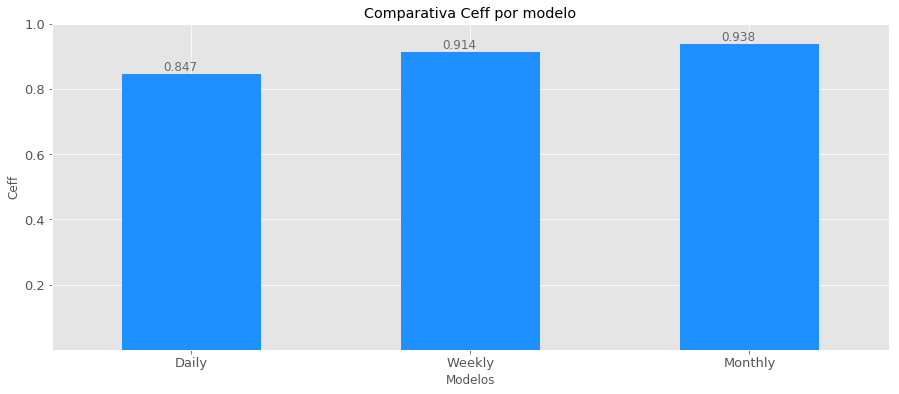

In [56]:
ax = ceff.plot(kind='bar', x='Modelos', y='Ceff', figsize=(15,6), color='dodgerblue', legend=None, fontsize=13)

ax.set_yticks([.2, .4, .6, .8, 1])
ax.set_xticklabels(ax.get_xticklabels(),rotation='horizontal')

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.01, \
            str(round((i.get_height()), 3)), fontsize=12, color='dimgrey')
    
plt.title('Comparativa Ceff por modelo')
plt.ylabel('Ceff')
plt.show()

Como podemos observar, el rendimiento de los modelos es bueno para la distribución diaria y muy bueno para la distribución semanal y mensual, bajo el *Criterio de Evaluación* por *Ceff*.

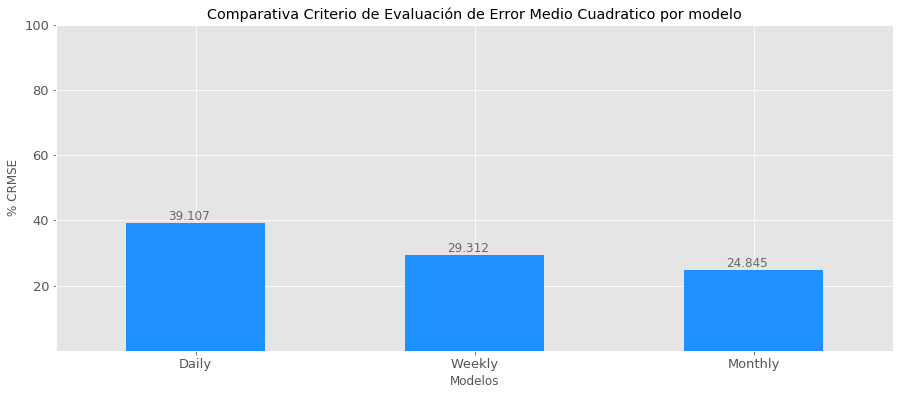

In [57]:
ax = cermse.plot(kind='bar', x='Modelos', y='CERMSE', figsize=(15,6), color='dodgerblue', legend=None, fontsize=13)

ax.set_yticks([20, 40, 60, 80, 100])
ax.set_xticklabels(ax.get_xticklabels(),rotation='horizontal')

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+1, \
            str(round((i.get_height()), 3)), fontsize=12, color='dimgrey')
    
plt.title('Comparativa Criterio de Evaluación de Error Medio Cuadratico por modelo')
plt.ylabel('% CRMSE')
plt.show()

Como podemos observar, el rendimiento de los modelos es bueno para la distribución diaria y muy bueno para la distribución semanal y mensual, bajo el *Criterio de Evaluación de Error Medio Cuadratico* por *CERMSE*.

## Fase V: Proyecciones del año 2003

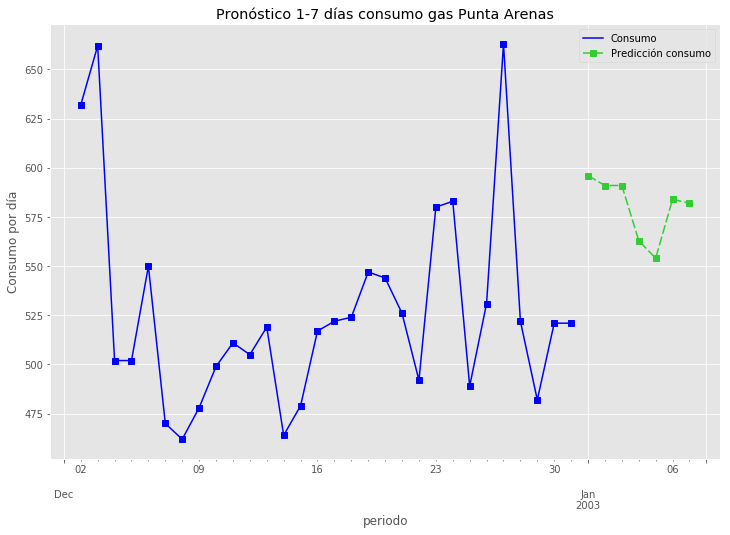

In [58]:
fig , g= plt.subplots(figsize=(12, 8))

g = timeseries.sort_values('date')[-30:].plot(x='date',y='Consumo',color='blue', marker='s', ax=g)
g = forecast_days.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo',marker='s', ax=g)

g.set_title('Pronóstico 1-7 días consumo gas Punta Arenas')

plt.ylabel('Consumo por día')
plt.show()

Los valores proyectado a 7 días del año 2003, son los siguientes:

| Periodo | Predicción consumo |
|------|------|
| 2003-01-01 | 596 |
| 2003-01-02 | 591 |
| 2003-01-03 | 591 |
| 2003-01-04 | 563 |
| 2003-01-05 | 554 |
| 2003-01-06 | 584 |
| 2003-01-07 | 582 |

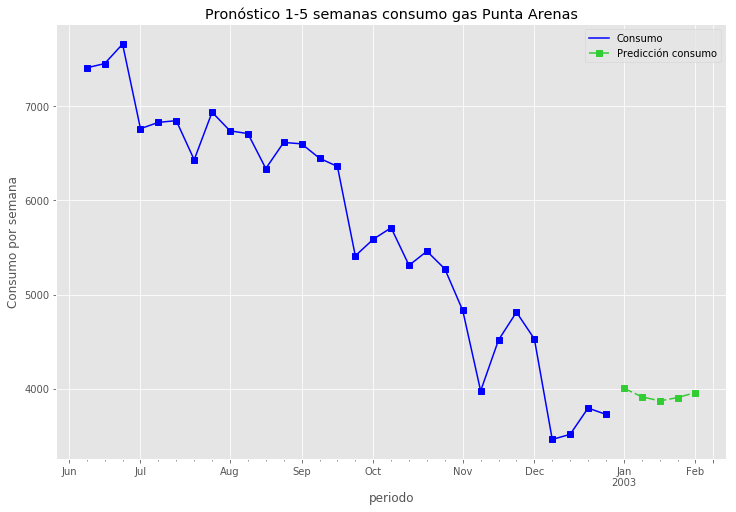

In [59]:
fig , g= plt.subplots(figsize=(12, 8))
#55
g = consum_week[-30:].plot(x='periodo',y='Consumo',color='blue', marker='s', ax=g)
g = forecast_weeks.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', marker='s', ax=g)

g.set_title('Pronóstico 1-5 semanas consumo gas Punta Arenas')

plt.ylabel('Consumo por semana')
plt.show()

Los valores proyectado a 5 semanas del año 2003, son los siguientes:

| Periodo | Predicción consumo |
|------|------|
| 2003-01-07 | 4007 |
| 2003-01-14 | 3916 |
| 2003-01-21 | 3872 |
| 2003-01-28 | 3907 |
| 2003-02-04 | 3961 |

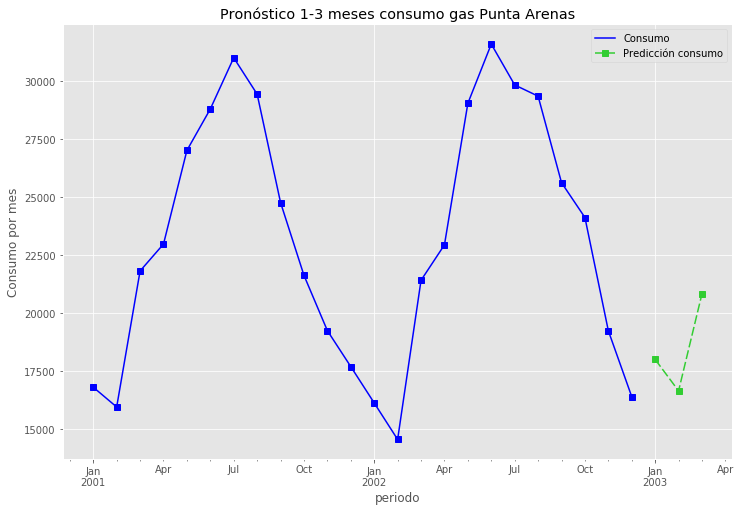

In [60]:
fig , g= plt.subplots(figsize=(12, 8))

g = consum_month[-24:].plot(x='periodo',y='Consumo',color='blue', marker='s', ax=g)
g = forecast_months.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', marker='s', ax=g)

g.set_title('Pronóstico 1-3 meses consumo gas Punta Arenas')

plt.ylabel('Consumo por mes')
plt.show()

Los valores proyectado a 3 meses del año 2003, son los siguientes:

| Periodo | Predicción consumo |
|------|------|
| 2003-01-01 | 18015 |
| 2003-02-01 | 16660 |
| 2003-03-01 | 20846 |